In [1]:
from scipy import stats
from scipy import integrate
from scipy import optimize
import matplotlib.pyplot as plt
import numpy as np

### Implementation of best responses

In [2]:
def BR_uniform(w) :
    """
    Returns the best response function against a the cdf G of a Uniform[0,w] :
    v \mapsto argmax_b (v-b)G(b)
    using the close-form expression
    """
    return lambda v : np.maximum(np.minimum(v/2,w),0)

In [3]:
def BR(rv,y_ub=50) :
    """
    Using optimize.minimize, it returns the best response function against the NON-NEGATIVE random variable rv :
    v \mapsto argmax_b (v-b)G(b)
    where G is the cdf of rv
    """
    if(rv.support()[1]!=np.inf) :
        y_ub = rv.support()[1]
    
    def br(v) :
        minus_utility_v = lambda b : -(v-b)*rv.cdf(b)
        return optimize.minimize_scalar(minus_utility_v,method="bounded",bounds=(rv.support()[0],y_ub)).x
    return br

In [4]:
def iBR_uniform(w) :
    """
    Returns the best response function against a the cdf G of a Uniform[0,w], using the close-form expression :
        /!\ given y \in [0,w] /!\ : y \mapsto 2*y 
    """
    return lambda y : 2*y

In [5]:
def iBR(rv) :
    return lambda y : optimize.root_scalar(lambda v : BR(rv)(v)-y,x0=0, x1=y).root

### BR : close-form expression vs numerical optimization

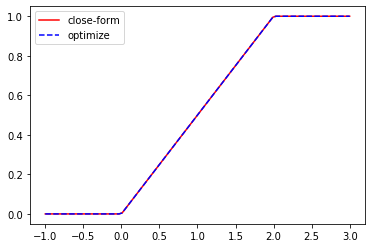

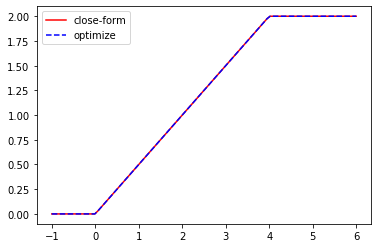

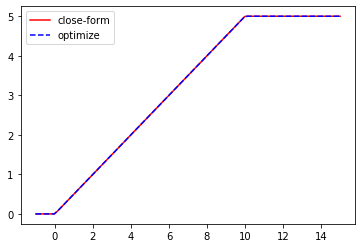

In [6]:
for w in [1,2,5] :
    x_ = np.linspace(-1,3*w,100)
    y_ = [BR(stats.uniform(loc=0,scale=w))(x) for x in x_]
    plt.plot(x_,BR_uniform(w)(x_),'r',label='close-form')
    plt.plot(x_,y_,'--b',label='optimize')
    plt.legend()
    plt.show()

### iBR : close-form expression vs numerical optimization

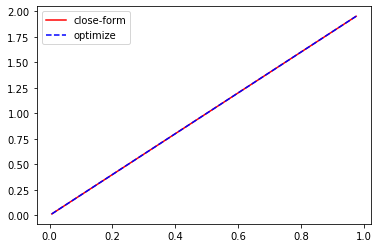

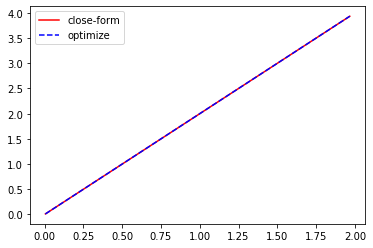

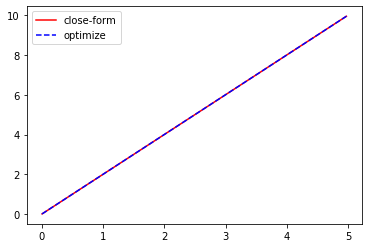

In [7]:
for w in [1,2,5] :
    x_ = stats.uniform(loc=0,scale=w).rvs(size=100)
    x_.sort()
    y_ = [iBR(stats.uniform(loc=0,scale=w))(x) for x in x_]
    plt.plot(x_,iBR_uniform(w)(x_),'r',label='close-form')
    plt.plot(x_,y_,'--b',label='optimize')
    plt.legend()
    plt.show()

### Best-response and iBR against a log-normal distribution

In [8]:
LN = stats.lognorm(1)

In [9]:
v_ = np.linspace(-1,5,100)
y_ = [ BR(LN)(v) for v in v_ ]
iy_ = [ iBR(LN)(y) for y in y_ ]

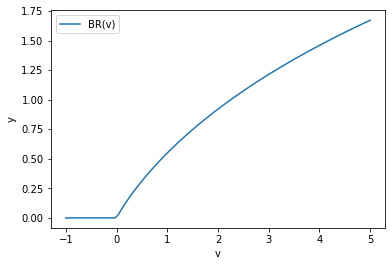

In [10]:
plt.plot(v_,y_,label='BR(v)')
plt.legend()
plt.xlabel("v")
plt.ylabel("y")
plt.show()

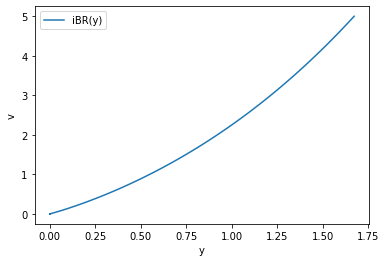

In [11]:
plt.plot(y_,iy_,label='iBR(y)')
plt.legend()
plt.xlabel("y")
plt.ylabel("v")
plt.show()

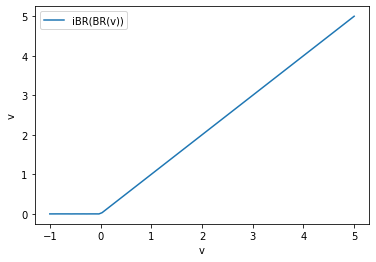

In [12]:
plt.plot(v_,iy_,label='iBR(BR(v))')
plt.legend()
plt.xlabel("v")
plt.ylabel("v")
plt.show()

### Numerical approximation of $\sum m_i(0)$

In [13]:
def f(v2,v1) :
    return integrate.quad(Gbeta,v2,v1)[0]-(v1-beta(v1))*G(beta(v1))

def build_integrand(f) :
    return lambda v2,v1 : f(v2,v1)*n*(n-1)*V.pdf(v1)*V.pdf(v2)*(V.cdf(v2)**(n-2))*(v2<=v1)

In [14]:
def sum_mi0_u(n,V,Y, v_ub=50,y_ub=50) :
    G = Y.cdf
    beta = BR_uniform(Y.support()[1])
    Gbeta = lambda v : G(beta(v))
    
    if(V.support()[1] != np.inf) :
        v_ub = V.support()[1]
    
    #without the factor (v2<=v1)
    def integrand(v2,v1) :
        return ( integrate.quad(Gbeta,v2,v1)[0]-(v1-beta(v1))*G(beta(v1)) )*( n*(n-1)*V.pdf(v1)*V.pdf(v2)*(V.cdf(v2)**(n-2)) )
    
    # Outer integral : x=v1
    # Inner integral : y=v2
    return integrate.dblquad(integrand, V.support()[0], v_ub, lambda x:V.support()[0], lambda x:x)[0]

In [16]:
def sum_mi0_v2(n,V,Y, v_ub=50,y_ub=50) :
    G = Y.cdf
    print(Y.support())
    beta = BR_uniform(Y.support()[1])
    ibeta = iBR_uniform(Y.support()[1])
    Gbeta = lambda v : G(beta(v))
    
    if(V.support()[1] != np.inf) :
        v_ub = V.support()[1]
    
    #without beta(v1) >= y*( v1>=v2 )
    def integrand(v2,y,v1) :
        return ( beta(v1)-max(v2,ibeta(y)) )*( n*(n-1)*V.pdf(v1)*V.pdf(v2)*(V.cdf(v2)**(n-2))*Y.pdf(y) )
    
    # Outer integral :  x=v1
    # Middle integral : y=y
    # Inner integral :  z=v2
    return integrate.tplquad(integrand, V.support()[0], v_ub, lambda x:Y.support()[0], lambda x:beta(x), lambda x,y:V.support()[0], lambda x,y : x)[0]

In [15]:
def sum_mi0(n,V,Y, v_ub=50,y_ub=50) :
    G = Y.cdf
    beta = BR(Y, y_ub)
    Gbeta = lambda v : G(beta(v))
    
    if(V.support()[1] != np.inf) :
        v_ub = V.support()[1]
    
    #without the factor (v2<=v1)
    def integrand(v2,v1) :
        return ( integrate.quad(Gbeta,v2,v1)[0]-(v1-beta(v1))*G(beta(v1)) )*( n*(n-1)*V.pdf(v1)*V.pdf(v2)*(V.cdf(v2)**(n-2)) )
    
    # Outer integral : x=v1
    # Inner integral : y=v2
    return integrate.dblquad(integrand, V.support()[0], v_ub, lambda x:V.support()[0], lambda x:x)[0]

In [48]:
def sum_mi0_atV(Y,y_ub=50) :
    G = Y.cdf
    beta = BR(Y, y_ub)
    Gbeta = lambda v : G(beta(v))
    
    if(V.support()[1] != np.inf) :
        v_ub = V.support()[1]
    
    def f(v2,v1) :
        return integrate.quad(Gbeta,v2,v1)[0]-(v1-beta(v1))*G(beta(v1))
    #without the factor (v2<=v1)
                                                                             
    return f

The setting is defined by : $(Y, V, n)$.

We consider that $V_1,\dots,V_n$ are i.i.d drawn from $V$

[0.1        0.53333333 0.96666667 1.4        1.83333333 2.26666667
 2.7        3.13333333 3.56666667 4.        ]
For n = 5 | V1,..., Vn iid from Unif[0,1] | Y from Unif[0,w]


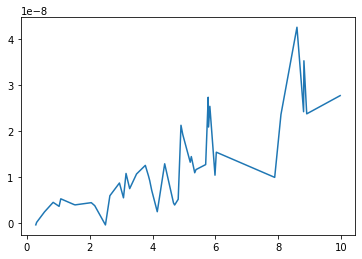

/Users/m.hihat/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  # Remove the CWD from sys.path while we load stuff.


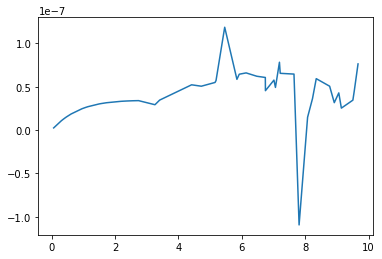

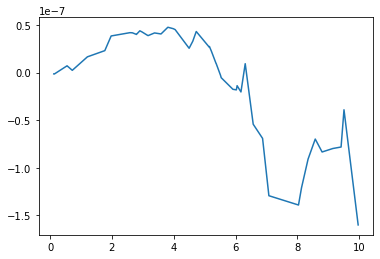

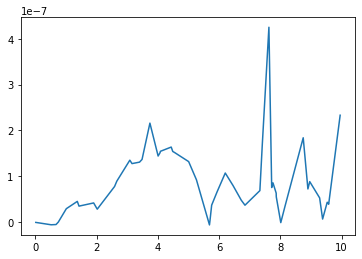

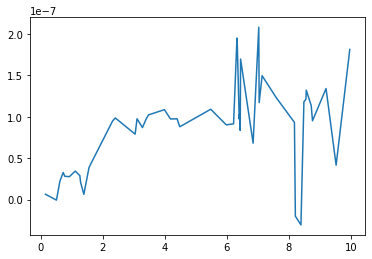

/Users/m.hihat/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  # Remove the CWD from sys.path while we load stuff.


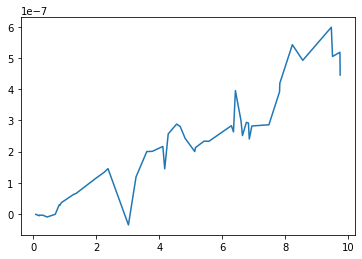

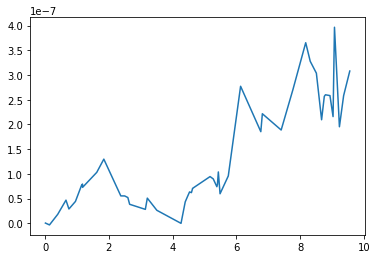

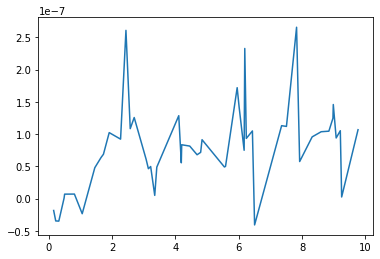

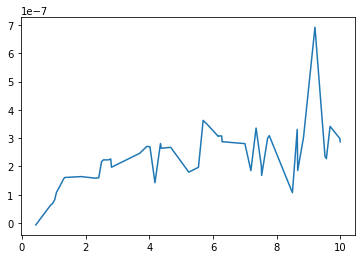

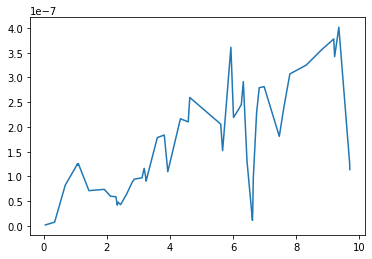

In [124]:
b_ = np.linspace(0.1, 4, 10)
print(b_)

N = 50

print("For n =",n,"| V1,..., Vn iid from Unif[0,1] | Y from Unif[0,w]")
for b in b_ :
    
    v1 = np.random.rand(N)*10
    v1.sort()
    
    Y = stats.beta(a=1,b=b,scale=10)
    output = [sum_mi0_atV(Y)(0,v1[i]) for i  in range(N) ]
    #max_output = -np.inf
    #for i in range(N) :
    #    tmp = sum_mi0_atV(Y)(0,v1[i])
    #    if(tmp >= max_output) :
    #        max_output = tmp
    plt.plot(v1,output)
    plt.show()

In [19]:
V = stats.uniform(loc=0,scale=1)
n = 5
b_ = [0.8, 1, 2]

print("For n =",n,"| V1,..., Vn iid from Unif[0,1] | Y from Unif[0,w]")
for b in b_ :
    Y = stats.beta(a=1,b=b)
    val = sum_mi0(n,V,Y)
    print("\t w =",w," | sum of mi(0) =",val)

For n = 5 | V1,..., Vn iid from Unif[0,1] | Y from Unif[0,w]


/Users/m.hihat/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  # This is added back by InteractiveShellApp.init_path()


KeyboardInterrupt: 

In [446]:
V = stats.uniform(loc=0,scale=1)
n = 5
w_ = [0.5, 0.6, 0.8, 1, 2, 4, 10]

print("For n =",n,"| V1,..., Vn iid from Unif[0,1] | Y from Unif[0,w]")
for w in w_ :
    Y = stats.uniform(loc=0,scale=w)
    val = sum_mi0_u(n,V,Y)
    print("\t w =",w," | sum of mi(0) =",val)

For n = 5 | V1,..., Vn iid from Unif[0,1] | Y from Unif[0,w]
	 w = 0.5  | sum of mi(0) = -0.23809523809523817
	 w = 0.6  | sum of mi(0) = -0.19841269841269843
	 w = 0.8  | sum of mi(0) = -0.14880952380952378
	 w = 1  | sum of mi(0) = -0.11904761904761908
	 w = 2  | sum of mi(0) = -0.05952380952380954
	 w = 4  | sum of mi(0) = -0.02976190476190477
	 w = 10  | sum of mi(0) = -0.011904761904761908


In [443]:
V = stats.uniform(loc=0,scale=1)
n = 5
w_ = [0.5, 0.6, 0.8, 1, 2, 4, 10]

print("For n =",n,"| V1,..., Vn iid from Unif[0,1] | Y from Unif[0,w]")
for w in w_ :
    Y = stats.uniform(loc=0,scale=w)
    val = sum_mi0_v2(n,V,Y)
    print("\t w =",w," | sum of mi(0) =",val)

For n = 5 | V1,..., Vn iid from Unif[0,1] | Y from Unif[0,w]
(0.0, 0.5)


KeyboardInterrupt: 

In [378]:
V = stats.uniform(loc=0,scale=1)
n = 50
w_ = [0.5, 0.6, 0.8, 1, 2, 4, 10]

print("For n =",n,"| V1,..., Vn iid from Unif[0,1] | Y from Unif[0,w]")
for w in w_ :
    Y = stats.uniform(loc=0,scale=w)
    val = sum_mi0(n,V,Y)
    print("\t w =",w," | sum of mi(0) =",val)

For n = 50 | V1,..., Vn iid from Unif[0,1] | Y = Unif[0,w]
	 w = 0.5  | sum of mi(0) = -0.4619155354449471
	 w = 0.6  | sum of mi(0) = -0.3849296128707893
	 w = 0.8  | sum of mi(0) = -0.2886972096530919
	 w = 1  | sum of mi(0) = -0.23095776772247356
	 w = 2  | sum of mi(0) = -0.11547888385666207
	 w = 4  | sum of mi(0) = -0.05773944193061839
	 w = 10  | sum of mi(0) = -0.023095776772247355


In [ ]:
Y = stats.uniform(loc=0,scale=1)
n = 50
w_ = [0.5, 0.6, 0.8, 1, 2, 4, 10]

print("For n =",n,"| V1,..., Vn iid from Unif[0,w] | Y from Unif[0,1]")
for w in w_ :
    V = stats.uniform(loc=0,scale=w)
    val = sum_mi0(n,V,Y)
    print("\t w =",w," | sum of mi(0) =",val)

In [457]:
V = stats.lognorm(s=0.5)
print(V.cdf(2))
print(V.cdf(3))
Y = stats.uniform(loc=0,scale=1)
n = 2

val = sum_mi0_u(n,V,Y,v_ub=2)
print("For n =",n,"| V1,..., Vn iid from Log-Norm(0,1) | Y from Log-Norm(0,1) | sum of mi(0) =",val)

val = sum_mi0_u(n,V,Y,v_ub=2.5)
print("For n =",n,"| V1,..., Vn iid from Log-Norm(0,1) | Y from Log-Norm(0,1) | sum of mi(0) =",val)

0.9171714809983016
0.985997794426055
For n = 2 | V1,..., Vn iid from Log-Norm(0,1) | Y from Log-Norm(0,1) | sum of mi(0) = -0.14420675446123668
For n = 2 | V1,..., Vn iid from Log-Norm(0,1) | Y from Log-Norm(0,1) | sum of mi(0) = -0.1734475863480601
